In [91]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# Set sklearn output to pandas dataframes
from sklearn import set_config
set_config(transform_output='pandas')

In [92]:
import optuna
import logging
import warnings

import warnings
warnings.filterwarnings('ignore', category=optuna.exceptions.ExperimentalWarning)

logger = logging.getLogger()

logger.setLevel(logging.INFO)  # Setup the root logger.
logger.addHandler(logging.FileHandler("./cache/optuna.log", mode="w"))

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

base_path = './prod/pca2'

def get_study(name):
    # create or load the study
    study = optuna.study.create_study(
        storage=f'sqlite:///{base_path}/cache/optuna.db',
        load_if_exists=True,
        directions=['maximize', 'minimize'],
        study_name=name,
        sampler=optuna.samplers.TPESampler(n_startup_trials=30),
        pruner=optuna.pruners.MedianPruner()
    )
    study.set_metric_names(['r2', 'mse'])
    return study


# Read the data

In [102]:
from src.selectvar import get_data

data, variables = get_data(window=7)
print(f'Mean before subsampling: {data["tavg"].mean()}')

# Filter data
data = data[(data['pmonin'] <= 9) & (data['pmonin'] >= 5)]
print(f'Mean after subsampling: {data["tavg"].mean()}')

7.86109599611841
16.03297287402342


In [94]:
# interpolate
data.sort_values(by=['pid', 'syear'], inplace=True)
data = data.groupby('pid').bfill(1).reset_index(names='pid')

# Preprocessing

In [95]:
def remove_duplicate_prefixes(strings):
    selected_strings = []
    removed_strings = []
    seen_prefixes = set()
    for string in strings:
        prefix = string.split('_')[0]
        if prefix not in seen_prefixes:
            seen_prefixes.add(prefix)
            selected_strings.append(string)
        else:
            removed_strings.append(string)
    return removed_strings

def get_category(cat):
    return variables.loc['category', variables.loc['category',:] == cat].index.tolist()


# Manuall dropping of variables (very clear cases)
columns_to_drop = [
    'fweight', 'fheight', 'valid', # imputation flags
    'pcs', 'mcs', #pca of other variables
    'plj0151'
]
columns_to_drop += get_category('key')
columns_to_drop += remove_duplicate_prefixes(data.columns)

data.drop(columns=columns_to_drop, inplace=True)
variables.drop(columns=columns_to_drop, inplace=True)

# drop nans
data[data<0] = np.nan
data.dropna(inplace=True)

# get weather data
weather = data[['prcp', 'tsun', 'wspd', 'pres', 'tavg']].copy()

data.drop(columns=['prcp', 'tsun', 'wspd', 'pres', 'tavg'], inplace=True)
variables.drop(columns=['prcp', 'tsun', 'wspd', 'pres', 'tavg'], inplace=True)

# get target
variables.drop(columns='plh0182', inplace=True)
y = data.pop('plh0182')

print(f'There are {data.shape[0]} rows remaining in the data')

There are 25008 rows remaining in the data


In [96]:
# do pca transform for all categories
pca_transformed = []
for category in tqdm(variables.loc['category',:].unique()):
    # Get subset of data in that category
    vars = get_category(category)
    subset = data.loc[:, vars].copy()
    subset_vars = variables.loc[:, vars].copy()

    # Get all nominal variables to create dummies
    cat_vars = subset_vars.loc['type', subset_vars.loc['type',:] == 'Nominal'].index.tolist()
    dummies = subset.loc[:, cat_vars].copy()
    # Remove the variables temporarily
    subset.drop(columns=cat_vars, inplace=True)
    subset_vars.drop(columns=cat_vars, inplace=True)
    # Add variables back as dummies
    for var in cat_vars:
        card = len(dummies[var].unique())
        if card >= 20:
            continue
        subset = pd.concat([subset, pd.get_dummies(dummies[var], sparse=False, drop_first=True, prefix=var)], axis=1)

100%|██████████| 7/7 [00:00<00:00, 29.89it/s]


In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

make_pl = lambda: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=4))]) 

data_complete = pd.DataFrame()
without_weather_args = []
with_weather_args = []
for category, _, X in pca_transformed:
    data_complete = pd.concat([data_complete, X], axis=1)
    pl = make_pl()
    without_weather_args.append((category, pl, X.columns.tolist()))
    with_weather_args.append((category, pl, X.columns.tolist()))
    
# add the weather data
pl = Pipeline(
    steps=[
        ('standard scaler'), StandardScaler()
    ]
)

# Add weather data
data_complete = pd.concat([data_complete, weather], axis=1)

# Create transformation pipelines
with_weather_args.append(('Weather', StandardScaler(), weather.columns))

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Create transformers
with_weather = ColumnTransformer(
    transformers=with_weather_args
)

# Transform data
with_weather.fit(data_complete)
data_complete = with_weather.fit_transform(data_complete)

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(data_complete, y, test_size=0.33)

In [99]:
# Bootstrapping
from sklearn.model_selection import StratifiedKFold
custom_cv = StratifiedKFold(n_splits=5)

In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from keras.regularizers import l1_l2
import tensorflow as tf

# Objective function for hp tuning
def objective(trial, est, suggestor):
    # suggest params
    params = suggestor(trial)
    est.set_params(**params)
    # suggest number of principle components
    r2_scores, mse_scores = [], []
    for train_idx, test_idx in custom_cv.split(X_train, y_train):
        # fit estimator
        est = est.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        # predict test set
        y_pred = est.predict(X_train.iloc[test_idx])
        y_true = y_train.iloc[test_idx]
        # compute the performance
        r2_scores.append(r2_score(y_true, y_pred))
        mse_scores.append(mean_squared_error(y_true, y_pred))
    return np.mean(r2_scores), np.mean(mse_scores)

############################
############################

# Suggesting functions for each model
def hb_suggestor(t):
    t.suggest_int('max_iter', 1, 1001, 10)
    t.suggest_int('max_depth', 3, 20, 1)
    t.suggest_int('min_samples_leaf', 10, 400, step=10)
    t.suggest_float('l2_regularization', 0.001, 100, log=True)
    return t.params

def sgd_suggestor(t):
    t.suggest_float('alpha', 1e-4, 1e-1, log=True)
    t.suggest_float('epsilon', 1e-2, 0.1)
    t.suggest_categorical('loss', ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error', 'huber'])
    t.suggest_categorical('penalty', ["l2", "l1", "elasticnet"])
    return t.params

# define a function that returns a Keras model
def create_model(n_input, n_hidden=1, units=None, activation='relu', l1=0.01, l2=0.01, dropout_rate=0.1):
    model = tf.keras.models.Sequential()
    if units is None:
        units = [10] * n_hidden
    model.add(tf.keras.layers.Dense(units[0], input_dim=n_input, activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.BatchNormalization())
    for i in range(0, n_hidden):
        model.add(tf.keras.layers.Dense(units[i], activation=activation, kernel_regularizer=l1_l2(l1=l1, l2=l2)))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

def mlp_suggestor(t):
    n_layers = t.suggest_int('n_hidden', 1, 2)
    units = [t.suggest_int(f'n_units_{i}', 1, 200) for i in range(n_layers)]
    learning_rate = t.suggest_float('optimizer__learning_rate', 1e-4, 1e-2)
    l1 = t.suggest_float("l1", 1e-5, 1e-1, log=True)
    l2 = t.suggest_float("l2", 1e-5, 1e-1, log=True)
    dropout_rate = t.suggest_float("dropout_rate", 0.1, 0.5)
    activation = t.suggest_categorical('activation', ['relu'])
    batch_size = t.suggest_int('batch_size', 100, 2000, 20)
    return {
        'n_hidden': n_layers,
        'units': units,
        'activation': activation,
        'optimizer__learning_rate': learning_rate,
        'batch_size': batch_size,
        'l1': l1,
        'l2': l2,
        'dropout_rate': dropout_rate
    }

############################
############################

# Define the models to optimize
hb = HistGradientBoostingRegressor(
    learning_rate=0.01, early_stopping=True
)

sgd = SGDRegressor(max_iter=20_000)

mlp = KerasRegressor(
    model=create_model,
    n_input=X_train.shape[1],
    n_hidden=1, units=None, activation='relu',
    epochs=100, batch_size=300, verbose=0,
    l1=0.01, l2=0.01, dropout_rate=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping],
    callbacks__patience=10,
    callbacks__monitor="loss"
)

models = [
    ('Multilayer Perceptron', mlp, mlp_suggestor),
    ('Hist Gradient Boosting Regressor', hb, hb_suggestor),
    ('Stochastic Gradient Descent', sgd, sgd_suggestor)
]

for name, model, func in models:
    study = get_study(name)
    study.optimize(lambda x: objective(x, model, func), timeout=60*60, n_trials=5)


2023-07-29 08:29:26.381424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 08:29:26.785341: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-29 08:29:33.610186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-29 08:29:33.818622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] suc

In [11]:
# Set best parameters
mlp_best_param = {
    'activation':'relu',
    'batch_size':900,
    'dropout_rate':0.15212163339472534,
    'l1':0.023389847913936505,
    'l2':0.01979929258667788,
    'units':[176],
    'optimizer__learning_rate':0.006793882945724138,
}
mlp.set_params(**mlp_best_param)
mlp.fit(X_train, y_train)

hb_best_param = {
    'l2_regularization':1.0961758390956304,
    'max_depth':15,
    'max_iter':901,
    'min_samples_leaf':160
}
hb.set_params(**hb_best_param)
hb.fit(X_train, y_train)

sgd_best_param = {
    'alpha':0.0004011555590543898,
    'epsilon':0.02676794507784599,
    'loss':'squared_error',
    'penalty':'l1'
}
sgd.set_params(**sgd_best_param)
sgd.fit(X_train, y_train)

SGDRegressor(alpha=0.0004011555590543898, epsilon=0.02676794507784599,
             max_iter=20000, penalty='l1')

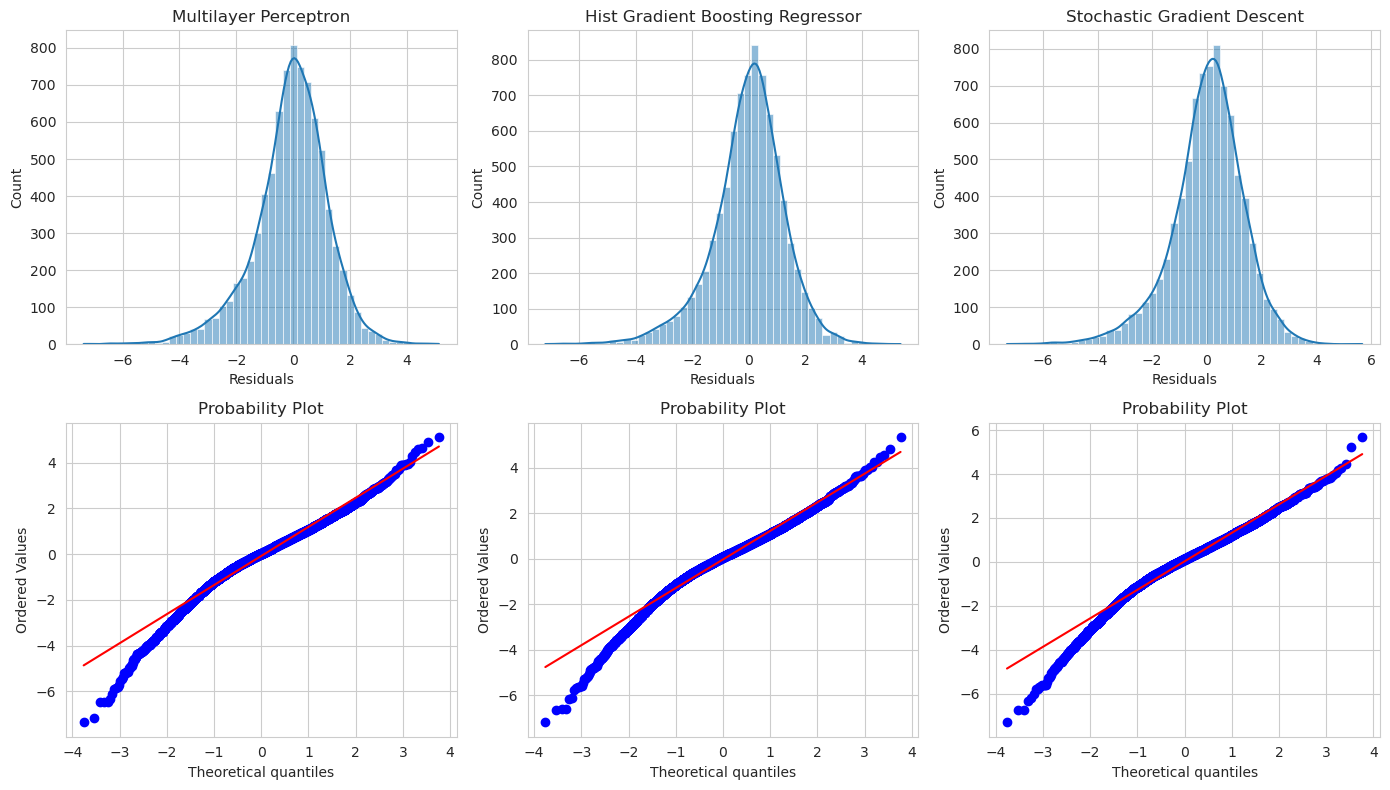

In [12]:
import scipy.stats as stats

fig, axs = plt.subplots(2, 3, sharey=False, figsize=(14, 8))
for i, (name, model, _) in enumerate(models):
    # Calculate residuals
    residuals = y_test - model.predict(X_test)
    
    # Create a histogram
    sns.histplot(residuals, kde=True, bins=50, ax=axs[0, i])
    axs[0, i].set_xlabel('Residuals')
    axs[0, i].set_title(name)

    # Create QQ plot
    stats.probplot(residuals, plot=axs[1, i])

plt.tight_layout()
plt.show()

In [13]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold

# make a bootstrap sampler
n_splits = 10
custom_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Create an empty dataframe to store the results
score_result_df = pd.DataFrame()
importance_df = pd.DataFrame()

# Iterate over the bootstraps
for train_idx, test_idx in tqdm(custom_cv.split(X_train, y_train), total=n_splits):
    # Get train part of bootstrap
    X_train_b = X_train.iloc[train_idx]
    y_train_b = y_train.iloc[train_idx]
    X_test_b = X_train.iloc[test_idx]
    y_test_b = y_train.iloc[test_idx]

    for name, model, func in models:
        # train all models
        model.fit(X_train_b, y_train_b)

        # Check how well the model is performing
        y_test_pred = model.predict(X_test_b)
        y_train_pred = model.predict(X_train_b)

        # Calculate R2
        score_test = r2_score(y_test_b, y_test_pred)
        score_train = r2_score(y_train_b, y_train_pred)
        # Calculate Mean Squared Error (MSE)
        mse_test = mean_squared_error(y_test_b, y_test_pred)
        mse_train = mean_squared_error(y_train_b, y_train_pred)

        # Save
        score_result_df = pd.concat(
            [score_result_df, pd.DataFrame({
                'r2': [score_test, score_train], 
                'mse':[mse_test, mse_train],
                'test': [True, False], 
                'model':[name, name]
            })], 
            axis=0
        )

        # Perform permutation importance
        result = permutation_importance(
            model, X_test_b, y_test_b, scoring='r2', n_repeats=1
        )
        temp = pd.DataFrame({
            'features': X_train_b.columns,
            'importance_mean': result['importances_mean'],
            'importance_std': result['importances_std'],
            'model':name
        })
        importance_df = pd.concat([importance_df, temp], axis=0)


# Save dataframes
score_result_df.to_csv(f"{base_path}/tables/score_results.csv", index=False)
importance_df.to_csv(f"{base_path}/tables/importance_results.csv", index=False)

100%|██████████| 10/10 [12:01<00:00, 72.13s/it]


In [14]:
from sklearn.inspection import partial_dependence
from sklearn.model_selection import StratifiedKFold

# compute interaction between Health_pca0 and Weather_tavg

n_splits = 10
#custom_cv = StratifiedBootstrapSampler(n_bootstraps=n_splits, n_sample_train=40_000, n_sample_test=30_000, n_test=0.33)
custom_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Create an empty list to store the results
partial_dependence_results = []

# Iterate over the bootstraps
for train_idx, test_idx in tqdm(custom_cv.split(X_train, y_train), total=n_splits):
    # Get train part of bootstrap
    X_train_b = X_train.iloc[train_idx]
    y_train_b = y_train.iloc[train_idx]
    X_test_b = X_train.iloc[test_idx]
    y_test_b = y_train.iloc[test_idx]

    for name, model, _ in models:
        # Fit the model
        model.fit(X_train_b, y_train_b)

        # Compute the partial dependence
        pdp_result_1 = partial_dependence(model, X_train_b, ['Health Status__pca1', 'Weather__tavg'], kind='average', method='brute', grid_resolution=20)
        pdp_result_2 = partial_dependence(model, X_train_b, ['Health Status__pca0', 'Weather__tavg'], kind='average', method='brute', grid_resolution=20)

        # Append to the overall results
        partial_dependence_results.append((name, pdp_result_1, pdp_result_2))


100%|██████████| 10/10 [44:49<00:00, 268.95s/it] 


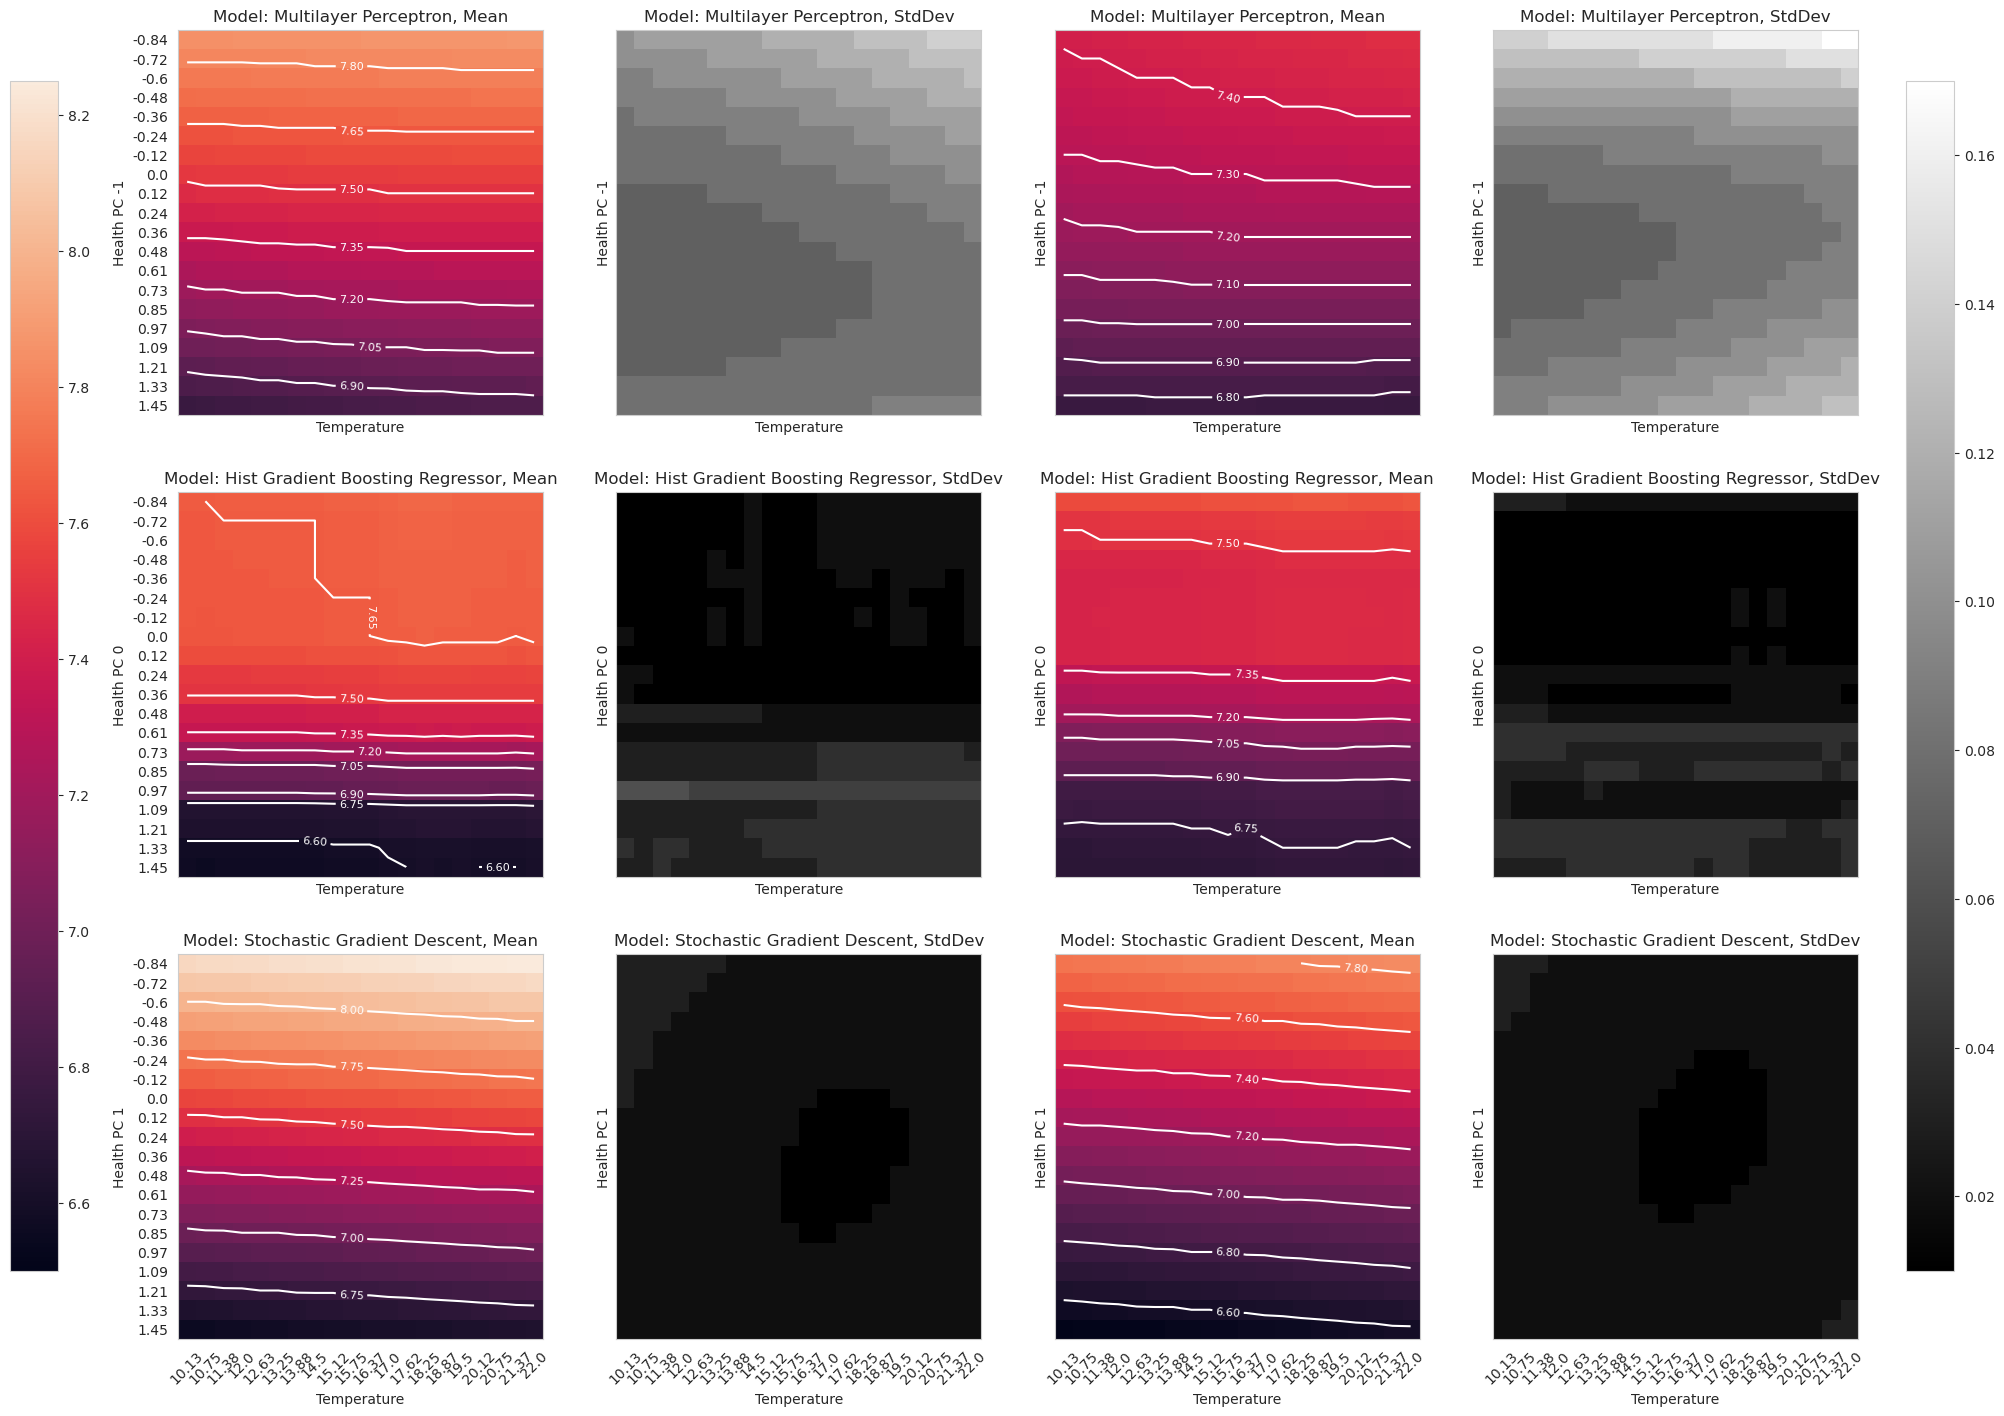

In [103]:
from collections import defaultdict

store = defaultdict(list)

for model, r1, r2 in partial_dependence_results:
    _, scaler, index = with_weather.transformers_[-1]
    i = np.where(index == 'tavg')[0][0]

    x1 = np.round(r1['values'][0], 2)
    y1 = r1['values'][1]
    z1 = r1['average'].squeeze()
    temp_array = np.zeros((len(y1), len(index)))
    temp_array[:, i] = y1
    y1_rescaled = np.round(scaler.inverse_transform(temp_array)[:, i], 2)

    x2 = np.round(r2['values'][0], 2)
    y2 = r2['values'][1]
    z2 = r2['average'].squeeze()
    temp_array = np.zeros((len(y2), len(index)))
    temp_array[:, i] = y2
    y2_rescaled = np.round(scaler.inverse_transform(temp_array)[:, i], 2)

    store[model].append((x1, y1_rescaled, z1, x2, y2_rescaled, z2))


fig, axs = plt.subplots(len(models), 4, figsize=(24, 17), sharex=True, sharey=True)

# Initialize vmin and vmax for mean and std heatmap colorbars
vmin_mean, vmax_mean = float('inf'), float('-inf')
vmin_std, vmax_std = float('inf'), float('-inf')

# First pass: calculate global min and max
for _, arrays in store.items():
    data = list(zip(*arrays))
    data = [np.concatenate(np.expand_dims(d, axis=0)) for d in data]
    _, _, z1, _, _, z2 = [np.mean(d, axis=0).round(2) for d in data]
    _, _, z1_std, _, _, _ = [np.std(d, axis=0).round(2) for d in data]
    _, _, _, _, _, z2_std = [np.std(d, axis=0).round(2) for d in data]

    vmin_mean = min(vmin_mean, z1.min(), z2.min())
    vmax_mean = max(vmax_mean, z1.max(), z2.max())
    vmin_std = min(vmin_std, z1_std.min(), z2_std.min())
    vmax_std = max(vmax_std, z1_std.max(), z2_std.max())

# Second pass: draw heatmaps with consistent colorbars
for i, (model, arrays) in enumerate(store.items()):
    data = list(zip(*arrays))
    data = [np.concatenate(np.expand_dims(d, axis=0)) for d in data]
    x1, y1, z1, x2, y2, z2 = [np.mean(d, axis=0).round(2) for d in data]
    _, _, z1_std, _, _, _ = [np.std(d, axis=0).round(2) for d in data]
    _, _, _, _, _, z2_std = [np.std(d, axis=0).round(2) for d in data]

    for idx, (x, y, z, z_std) in enumerate([(x1, y1, z1, z1_std), (x2, y2, z2, z2_std)]):
        im_mean = axs[i, 2*idx].imshow(z, aspect='auto', interpolation='nearest', vmin=vmin_mean, vmax=vmax_mean)
        contour = axs[i, 2*idx].contour(z, colors='white', extend='both')  # Add contour lines
        im_std = axs[i, 2*idx+1].imshow(z_std, aspect='auto', interpolation='nearest', cmap='gray', vmin=vmin_std, vmax=vmax_std)

        # Annotate countours
        axs[i, 2*idx].clabel(contour, inline=True, fontsize=8, fmt='%1.2f')  # Add contour labels

        # Set title
        axs[i, 2*idx].set_title(f'Model: {model}, Mean')
        axs[i, 2*idx+1].set_title(f'Model: {model}, StdDev')

        # Remove Gridlines
        axs[i, 2*idx].grid(False)
        axs[i, 2*idx+1].grid(False)
    
        # Setting the x and y ticks
        axs[i, 2*idx].set_yticks(np.arange(len(x)))
        axs[i, 2*idx].set_xticks(np.arange(len(y)))
        axs[i, 2*idx].set_yticklabels(x)
        axs[i, 2*idx].set_xticklabels(y, rotation=45)
        axs[i, 2*idx].set_ylabel(f'Health PC {i-1}')
        axs[i, 2*idx].set_xlabel('Temperature')

        axs[i, 2*idx+1].set_yticks(np.arange(len(x)))
        axs[i, 2*idx+1].set_xticks(np.arange(len(y)))
        axs[i, 2*idx+1].set_yticklabels(x)
        axs[i, 2*idx+1].set_xticklabels(y, rotation=45)
        axs[i, 2*idx+1].set_ylabel(f'Health PC {i-1}')
        axs[i, 2*idx+1].set_xlabel('Temperature')

# Add colorbars
fig.subplots_adjust(right=0.8)
cbar_ax_std = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(im_std, cax=cbar_ax_std)

fig.subplots_adjust(left=0.1)
cbar_ax_mean = fig.add_axes([0.03, 0.15, 0.02, 0.7])
fig.colorbar(im_mean, cax=cbar_ax_mean)


plt.savefig(f'{base_path}/plots/partial_dependence.pdf', dpi=500, bbox_inches='tight', pad_inches=0)